<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/VAE_gemini1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


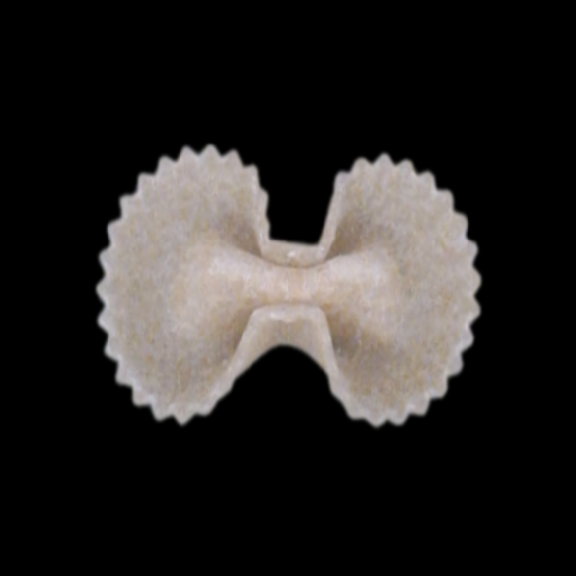

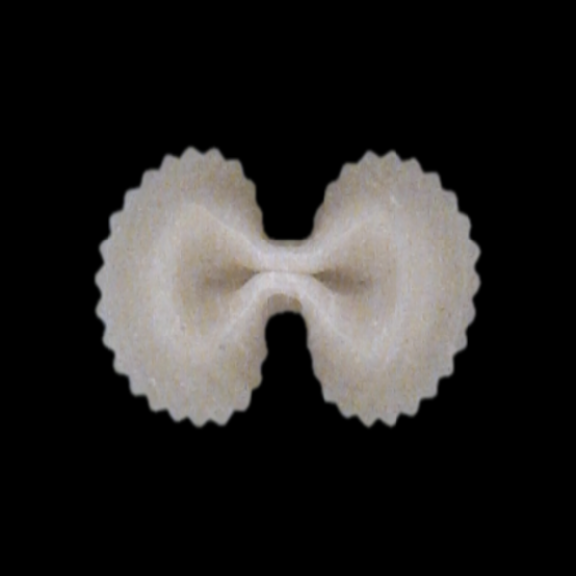

In [ ]:
import cv2 as cv2
from google.colab import drive
drive.mount('/content/drive')

image_folder = "/content/drive/MyDrive/shear1"

test_images = "/content/drive/MyDrive/shear1malas"


from PIL import Image
image_path = '/content/drive/MyDrive/shear1/0000.png'  # Replace with the actual path
img = Image.open(image_path)
display(img)
image_path = '/content/drive/MyDrive/shear1malas/0096.png'  # Replace with the actual path
img = Image.open(image_path)
display(img)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import cv2 as cv2

In [ ]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

############################<br>
--- Load Images ---

In [ ]:
def load_images(folder_path, target_size=(576, 576)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("RGB").resize(target_size)
            images.append(np.array(img) / 255.0)  # Normalize to [0, 1]
    return np.array(images)
##############################

############################<br>
--- Create VAE ---

In [ ]:
def create_autoencoder(input_shape=(576, 576, 3), latent_dim=16):
    # Encoder
    encoder_inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_inputs)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    encoded_features = layers.MaxPooling2D((2, 2), padding="same")(x) # Assign the output of MaxPooling2D to a variable
    x = layers.Flatten()(encoded_features) # Use the assigned variable
    latent_space = layers.Dense(latent_dim, activation="relu")(x)
    encoder = keras.Model(encoder_inputs, latent_space, name="encoder")

    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(encoded_features.shape[1:]), activation='relu')(latent_inputs) # Use encoded_features.shape to get shape
    x = layers.Reshape(target_shape=encoded_features.shape[1:])(x) # Use encoded_features.shape to get shape
    x = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_outputs = layers.Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    #vae
    autoencoder = tf.keras.Model(inputs=encoder.inputs, outputs=decoder(encoder.output))
    return autoencoder

In [ ]:
def calculate_reconstruction_error(autoencoder, images):
    reconstructed_images = autoencoder.predict(images)
    errors = np.mean(np.square(images - reconstructed_images).reshape(len(images), -1), axis = 1) #average per image
    return errors

############################

In [ ]:



images = load_images(image_folder)
input_shape = images[0].shape
print("input shape", input_shape)
# Split data to allow to test the model
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

input shape (576, 576, 3)


2. Model Creation

In [ ]:
autoencoder = create_autoencoder(input_shape)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00015), loss='mse')

###################<br>
3. Model Training

In [ ]:
epochs = 1
batch_size = 1

In [ ]:
autoencoder.fit(train_images, train_images, epochs=epochs, batch_size=batch_size, shuffle=True)

58/77 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.1725

4. Anomaly Detection

Compute reconstruction errors on the training images to compute a threshold

In [ ]:
train_errors = calculate_reconstruction_error(autoencoder, train_images)

Compute threshold using high percentile

In [ ]:
threshold = np.percentile(train_errors, 95)
print(f'Threshold value set to: {threshold}')

In [ ]:
## test_images = "C:\\Users\libro\OneDrive\Escritorio\malas/"

In [ ]:
test_errors = calculate_reconstruction_error(autoencoder, test_images)

 Compare test error with threshold and flag anomaly

In [ ]:
anomalies = np.array(test_errors) > threshold

In [ ]:
print(f'Detected anomalies:{anomalies}')

To vizualize the output

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

Display 4 normal and 4 anomalous samples:

In [ ]:
n_anomalies = 0
n_samples = 0
for i, sample in enumerate(test_images):
    if n_samples >= 4 and n_anomalies>=4:
        break;
    if anomalies[i]:
        if n_anomalies>=4:
            continue;
        axes[i].imshow(sample)
        axes[i].set_title("Anomaly")
        n_anomalies +=1;
    else:
        if n_samples >=4:
            continue;
        axes[i].imshow(sample)
        axes[i].set_title("Normal")
        n_samples +=1;

In [ ]:
plt.tight_layout()
plt.show()